# Energy Consumption Forecasting - LGBM Model Training

This notebook trains a LightGBM model for energy consumption forecasting using the preprocessed dataset.

## Objectives:
1. Load the preprocessed dataset from data preprocessing pipeline
2. Implement time series train-test split for temporal data
3. Train and optimize LightGBM model with hyperparameter tuning
4. Evaluate model performance with comprehensive metrics
5. Generate predictions and visualizations
6. Save the trained model for deployment

## Key Features:
- **Time Series Split**: Respects temporal order for realistic evaluation
- **Feature Importance Analysis**: Understand which features drive predictions
- **Comprehensive Evaluation**: Multiple metrics including RMSE, MAE, MAPE
- **Hyperparameter Optimization**: Automated tuning for best performance

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# LightGBM and ML libraries
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import gc

# Configuration
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")
print(f"LightGBM version: {lgb.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

# Set random seed for reproducibility
np.random.seed(42)

Libraries imported successfully!
LightGBM version: 4.6.0
Pandas version: 2.3.3
NumPy version: 2.3.4


## 1. Data Loading and Exploration

In [3]:
# Load the preprocessed dataset
print("Loading preprocessed dataset...")
data_path = '/Users/saatwik/Documents/Energy-consumption-forecasting/data/'

try:
    # Load main dataset
    df = pd.read_csv(f"{data_path}processed_dataset.csv")
    print(f"✓ Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    
    # Load feature names
    try:
        with open(f"{data_path}feature_names.txt", 'r') as f:
            feature_names = [line.strip() for line in f.readlines()]
        print(f"✓ Feature names loaded: {len(feature_names)} features")
    except FileNotFoundError:
        # Fallback: extract feature names from dataset
        feature_names = [col for col in df.columns if col != 'meter_reading']
        print(f"! Feature names file not found, extracted from dataset: {len(feature_names)} features")
    
except FileNotFoundError:
    print("❌ Preprocessed dataset not found!")
    print("Please run the preprocessing notebook first to generate 'processed_dataset.csv'")
    print("Expected location: /Users/saatwik/Documents/Energy-consumption-forecasting/data/processed_dataset.csv")
    raise

# Basic dataset information
print(f"\n{'='*60}")
print("DATASET OVERVIEW")
print(f"{'='*60}")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nTarget Variable (meter_reading) Statistics:")
print(df['meter_reading'].describe())

print(f"\nMissing Values:")
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
else:
    print("No missing values found ✓")

print(f"\nData Types:")
print(df.dtypes.value_counts())

# Check for essential columns
essential_cols = ['building_id', 'meter_reading']
missing_essential = [col for col in essential_cols if col not in df.columns]
if missing_essential:
    print(f"\n❌ Missing essential columns: {missing_essential}")
else:
    print(f"\n✓ All essential columns present")

print(f"\nUnique buildings: {df['building_id'].nunique()}")
print(f"Building ID range: {df['building_id'].min()} to {df['building_id'].max()}")

Loading preprocessed dataset...
✓ Dataset loaded successfully!
Dataset shape: (1019524, 65)
✓ Feature names loaded: 64 features

DATASET OVERVIEW
Shape: (1019524, 65)
Memory usage: 563.93 MB

Target Variable (meter_reading) Statistics:
count    1.019524e+06
mean     4.090041e+02
std      1.844360e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.170000e-02
max      9.401151e+03
Name: meter_reading, dtype: float64

Missing Values:
No missing values found ✓

Data Types:
float64    39
int64      25
object      1
Name: count, dtype: int64

✓ All essential columns present

Unique buildings: 1449
Building ID range: 0 to 1448


## 2. Data Preparation and Time Series Splitting

In [ ]:
# Prepare the data for modeling
print("Preparing data for modeling...")

# Check if timestamp column exists for time series split
has_timestamp = 'timestamp' in df.columns

if has_timestamp:
    print("✓ Timestamp column found - using time-based splitting")
    # Convert timestamp to datetime if it's not already
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort by timestamp for proper time series splitting
    df = df.sort_values('timestamp').reset_index(drop=True)
    print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    # Calculate split point (use last 20% for testing)
    n_total = len(df)
    split_idx = int(n_total * 0.8)
    
    print(f"Training data: {df['timestamp'].iloc[0]} to {df['timestamp'].iloc[split_idx-1]}")
    print(f"Testing data: {df['timestamp'].iloc[split_idx]} to {df['timestamp'].iloc[-1]}")
    
else:
    print("! No timestamp column found - using random sampling for split")
    # Shuffle the data for random split
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    split_idx = int(len(df) * 0.8)

# Prepare features and target
target_col = 'meter_reading'
# Exclude timestamp and other non-numeric columns from features
exclude_cols = [target_col, 'timestamp']
feature_cols = [col for col in feature_names if col in df.columns and col not in exclude_cols]

print(f"\nFeature preparation:")
print(f"Available features: {len(feature_cols)}")
print(f"Target variable: {target_col}")

# Check for any problematic columns (non-numeric or datetime types)
problematic_cols = []
for col in feature_cols:
    if col in df.columns:
        dtype = df[col].dtype
        if dtype == 'object':
            unique_vals = df[col].nunique()
            if unique_vals > 100:  # Too many categories
                problematic_cols.append(col)
                print(f"! Warning: {col} has {unique_vals} unique values (object type)")
        elif 'datetime' in str(dtype).lower():
            problematic_cols.append(col)
            print(f"! Warning: {col} is datetime type, excluding from features")
        elif 'timedelta' in str(dtype).lower():
            problematic_cols.append(col)
            print(f"! Warning: {col} is timedelta type, excluding from features")

if problematic_cols:
    print(f"Removing problematic columns: {problematic_cols}")
    feature_cols = [col for col in feature_cols if col not in problematic_cols]

print(f"Final features for modeling: {len(feature_cols)}")

# Create feature matrix and target vector
X = df[feature_cols].copy()
y = df[target_col].copy()

print(f"\nData shapes:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Verify all features are numeric
print(f"\nFeature data types validation:")
non_numeric_cols = []
datetime_cols = []

for col in X.columns:
    dtype = X[col].dtype
    dtype_str = str(dtype).lower()
    
    if 'datetime' in dtype_str or 'timedelta' in dtype_str:
        datetime_cols.append(col)
        print(f"  {col}: {dtype} (DATETIME - REMOVING)")
    elif dtype not in ['int64', 'float64', 'int32', 'float32', 'int8', 'int16', 'float16']:
        non_numeric_cols.append(col)
        print(f"  {col}: {dtype} (NON-NUMERIC - REMOVING)")
    else:
        print(f"  {col}: {dtype} ✓")

# Remove ALL problematic columns
problematic_columns = non_numeric_cols + datetime_cols
if problematic_columns:
    print(f"\nRemoving problematic columns: {problematic_columns}")
    X = X.drop(columns=problematic_columns)
    feature_cols = [col for col in feature_cols if col not in problematic_columns]
    print(f"Updated feature count: {len(feature_cols)}")

# Final verification - double check no datetime columns remain
print(f"\nFinal verification of data types:")
final_bad_cols = []
for col in X.columns:
    dtype_str = str(X[col].dtype).lower()
    if 'datetime' in dtype_str or 'timedelta' in dtype_str or 'object' in dtype_str:
        final_bad_cols.append(col)
        print(f"  WARNING: {col} still has problematic dtype: {X[col].dtype}")

if final_bad_cols:
    print(f"Emergency removal of remaining problematic columns: {final_bad_cols}")
    X = X.drop(columns=final_bad_cols)
    feature_cols = [col for col in feature_cols if col not in final_bad_cols]
    print(f"Final feature count: {len(feature_cols)}")
else:
    print("✓ All columns verified as numeric")

# Handle any remaining missing values
if X.isnull().sum().sum() > 0:
    print("\n! Found missing values in features, filling with median...")
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            median_val = X[col].median()
            X[col].fillna(median_val, inplace=True)
            print(f"  Filled {col} missing values with median: {median_val:.2f}")
else:
    print("\n✓ No missing values found in features")

# Convert all columns to float64 for consistency
print(f"\nConverting all features to float64 for LightGBM compatibility...")
for col in X.columns:
    if X[col].dtype != 'float64':
        X[col] = X[col].astype('float64')
        print(f"  Converted {col} from {X[col].dtype} to float64")

print(f"\nFinal feature matrix info:")
print(f"  Shape: {X.shape}")
print(f"  All dtypes: {X.dtypes.value_counts().to_dict()}")

# Time series split
X_train = X.iloc[:split_idx].copy()
X_test = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_test = y.iloc[split_idx:].copy()

print(f"\nTrain-Test Split Results:")
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Features: {X_train.shape[1]}")

# Basic statistics
print(f"\nTarget variable statistics:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

# Memory cleanup
gc.collect()
print("✓ Data preparation completed!")

Preparing data for modeling...
✓ Timestamp column found - using time-based splitting
Date range: 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Training data: 2016-01-01 00:00:00 to 2016-10-10 14:00:00
Testing data: 2016-10-10 14:00:00 to 2016-12-31 23:00:00

Feature preparation:
Available features: 64
Target variable: meter_reading
Final features for modeling: 64

Data shapes:
Features (X): (1019524, 64)
Target (y): (1019524,)
Date range: 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Training data: 2016-01-01 00:00:00 to 2016-10-10 14:00:00
Testing data: 2016-10-10 14:00:00 to 2016-12-31 23:00:00

Feature preparation:
Available features: 64
Target variable: meter_reading
Final features for modeling: 64

Data shapes:
Features (X): (1019524, 64)
Target (y): (1019524,)

Train-Test Split Results:
Training set: 815,619 samples (80.0%)
Test set: 203,905 samples (20.0%)
Features: 64

Target variable statistics:
Train - Mean: 402.43, Std: 1832.66
Test  - Mean: 435.32, Std: 1890.20
✓ Data preparation

## 3. LightGBM Model Training

In [8]:
# Define LGBM parameters with optimized settings
print("Setting up LightGBM model...")

# Base parameters for LightGBM
lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 42,
    'n_jobs': -1
}

# Final safety check before creating LightGBM datasets
print("Pre-training data validation...")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check for any remaining problematic dtypes
print("Final dtype check:")
train_dtypes = X_train.dtypes
problematic_train_cols = []
for col in X_train.columns:
    dtype_str = str(train_dtypes[col]).lower()
    if 'datetime' in dtype_str or 'object' in dtype_str:
        problematic_train_cols.append(col)
        print(f"  PROBLEM: {col} has dtype {train_dtypes[col]}")

if problematic_train_cols:
    print(f"Emergency fix: Converting problematic columns to float64")
    for col in problematic_train_cols:
        try:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce').astype('float64')
            X_test[col] = pd.to_numeric(X_test[col], errors='coerce').astype('float64')
            print(f"  Converted {col} to float64")
        except Exception as e:
            print(f"  Failed to convert {col}: {e}")
            # Drop the column entirely if conversion fails
            X_train = X_train.drop(columns=[col])
            X_test = X_test.drop(columns=[col])
            print(f"  Dropped {col} entirely")

print("✓ Data validation completed")

# Create LightGBM datasets with error handling
print("Creating LightGBM datasets...")
try:
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    print("✓ LightGBM datasets created successfully")
except Exception as e:
    print(f"❌ Error creating LightGBM datasets: {e}")
    print("Dataset dtypes at error:")
    print(X_train.dtypes.value_counts())
    raise

# Time series cross-validation for hyperparameter tuning
print("Performing time series cross-validation...")

def time_series_cv_lgbm(params, X, y, n_splits=3, test_size=0.2):
    """Perform time series cross-validation for LGBM"""
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=int(len(X) * test_size))
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"  Fold {fold + 1}/{n_splits}")
        
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Create datasets
        fold_train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
        fold_valid_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=fold_train_data)
        
        # Train model
        model = lgb.train(
            params,
            fold_train_data,
            valid_sets=[fold_valid_data],
            num_boost_round=1000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(0)
            ]
        )
        
        # Predict and score
        y_pred = model.predict(X_fold_val)
        rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
        cv_scores.append(rmse)
        print(f"    Fold {fold + 1} RMSE: {rmse:.4f}")
    
    avg_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    print(f"  Average CV RMSE: {avg_score:.4f} ± {std_score:.4f}")
    
    return avg_score, cv_scores

# Test different hyperparameter combinations
print("\nHyperparameter optimization...")
param_combinations = [
    # Base model
    {**lgbm_params, 'num_leaves': 31, 'learning_rate': 0.1},
    # More complex model
    {**lgbm_params, 'num_leaves': 50, 'learning_rate': 0.05},
    # Less complex model
    {**lgbm_params, 'num_leaves': 20, 'learning_rate': 0.15},
    # Regularized model
    {**lgbm_params, 'num_leaves': 31, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1},
]

best_score = float('inf')
best_params = None
cv_results = []

for i, params in enumerate(param_combinations):
    print(f"\nTesting parameter combination {i+1}/{len(param_combinations)}:")
    print(f"  num_leaves: {params['num_leaves']}, learning_rate: {params['learning_rate']}")
    
    try:
        avg_score, scores = time_series_cv_lgbm(params, X_train, y_train, n_splits=3)
        cv_results.append({
            'params': params.copy(),
            'avg_score': avg_score,
            'std_score': np.std(scores),
            'scores': scores
        })
        
        if avg_score < best_score:
            best_score = avg_score
            best_params = params.copy()
            print(f"  ✓ New best score: {avg_score:.4f}")
        
    except Exception as e:
        print(f"  ❌ Error with this combination: {e}")

print(f"\n{'='*60}")
print("HYPERPARAMETER OPTIMIZATION RESULTS")
print(f"{'='*60}")

if best_params is None:
    print("❌ No successful parameter combinations found!")
    print("Using default parameters as fallback...")
    best_params = lgbm_params.copy()
    best_score = float('inf')
    print(f"Fallback parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
else:
    print(f"Best CV RMSE: {best_score:.4f}")
    print(f"Best parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

# Train final model with best parameters
print(f"\n{'='*60}")
print("TRAINING FINAL MODEL")
print(f"{'='*60}")

try:
    final_model = lgb.train(
        best_params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(100)
        ]
    )
    
    print(f"✓ Final model trained!")
    print(f"Best iteration: {final_model.best_iteration}")
    print(f"Best score: {final_model.best_score['valid_0']['rmse']:.4f}")
    
except Exception as e:
    print(f"❌ Error training final model: {e}")
    print("Trying simplified training approach...")
    
    # Fallback training with minimal parameters
    simple_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'random_state': 42
    }
    
    final_model = lgb.train(
        simple_params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=100,
        callbacks=[lgb.log_evaluation(0)]
    )
    
    print(f"✓ Simplified model trained!")
    print(f"Final iteration: {final_model.num_trees()}")
    if hasattr(final_model, 'best_score') and 'valid_0' in final_model.best_score:
        print(f"Final score: {final_model.best_score['valid_0']['rmse']:.4f}")
    else:
        print("Score: Available after evaluation")

# Memory cleanup
gc.collect()

Setting up LightGBM model...
Pre-training data validation...
X_train shape: (815619, 64)
X_test shape: (203905, 64)
y_train shape: (815619,)
y_test shape: (203905,)
Final dtype check:
  PROBLEM: timestamp has dtype datetime64[ns]
Emergency fix: Converting problematic columns to float64
  Converted timestamp to float64
✓ Data validation completed
Creating LightGBM datasets...
✓ LightGBM datasets created successfully
Performing time series cross-validation...

Hyperparameter optimization...

Testing parameter combination 1/4:
  num_leaves: 31, learning_rate: 0.1
  Fold 1/3
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[972]	valid_0's rmse: 278.736
Did not meet early stopping. Best iteration is:
[972]	valid_0's rmse: 278.736
    Fold 1 RMSE: 278.7362
  Fold 2/3
    Fold 1 RMSE: 278.7362
  Fold 2/3
Training until validation scores don't improve for 50 rounds
Training 

3014

## 4. Model Evaluation and Performance Analysis

Generating predictions...
MODEL PERFORMANCE EVALUATION

Training Set Metrics:
---------------------
RMSE           :    67.16
MAE            :    18.65
R²             :   0.9987
MAPE           : 79401300716.18%
Mean Residual  :    -0.00
Std Residual   :    67.16

Test Set Metrics:
-----------------
RMSE           :   245.33
MAE            :    54.13
R²             :   0.9832
MAPE           : 238687277349.18%
Mean Residual  :     3.73
Std Residual   :   245.30

Performance Comparison:
------------------------------
RMSE   - Train: 67.16, Test: 245.33 (Δ: +265.3%)
MAE    - Train: 18.65, Test: 54.13 (Δ: +190.2%)
R²     - Train: 0.9987, Test: 0.9832 (Δ: -1.55%)
MAPE   - Train: 79401300716.18%, Test: 238687277349.18% (Δ: +159285976633.00%)

Overfitting Analysis:
⚠️  Possible overfitting detected (RMSE increase: 265.3%)

CREATING PERFORMANCE VISUALIZATIONS
MODEL PERFORMANCE EVALUATION

Training Set Metrics:
---------------------
RMSE           :    67.16
MAE            :    18.65
R²         

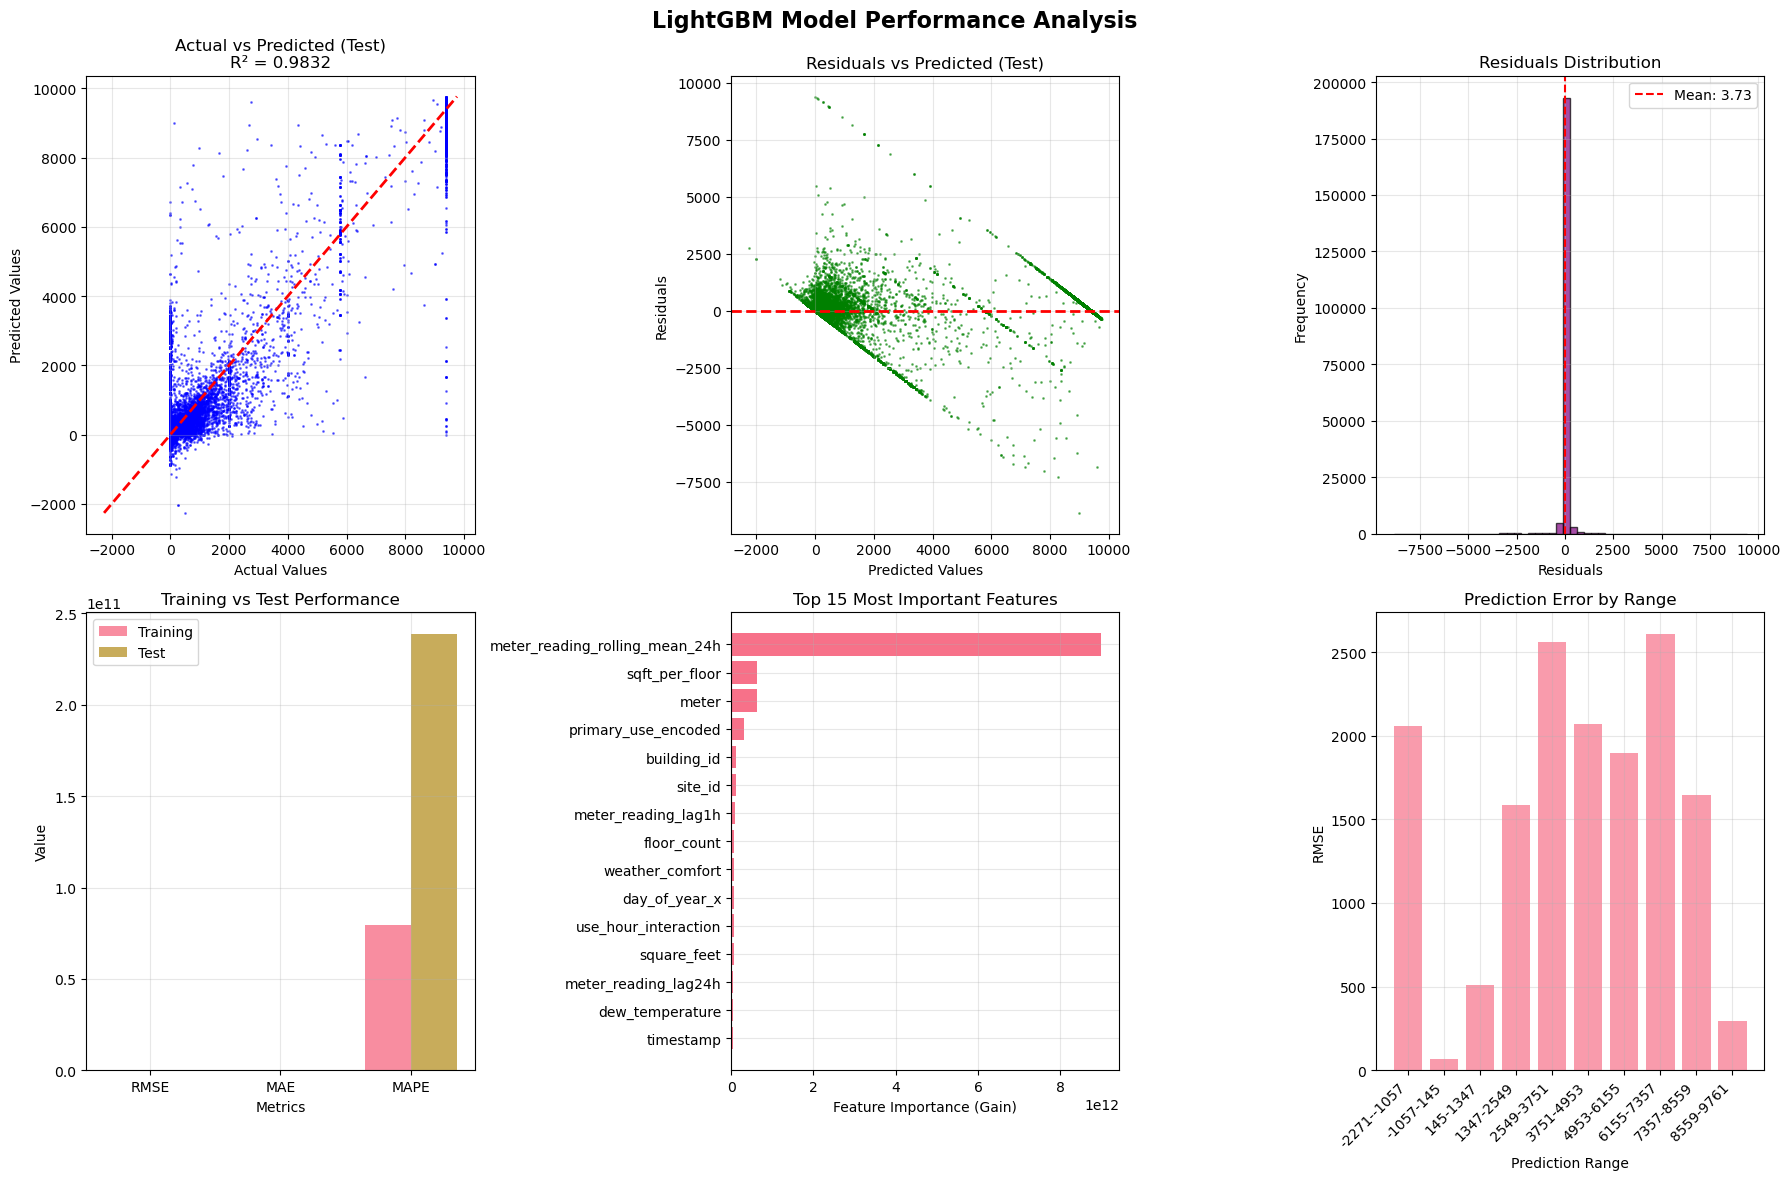


Top 10 Most Important Features:
--------------------------------------------------
 1. meter_reading_rolling_mean_24h 8988005613988.8
 2. sqft_per_floor            628021807213.0
 3. meter                     619733524858.4
 4. primary_use_encoded       301906510836.4
 5. building_id               115486456015.3
 6. site_id                   114162683369.7
 7. meter_reading_lag1h       92096381019.6
 8. floor_count               66578086254.2
 9. weather_comfort           62920072732.4
10. day_of_year_x             59833349592.6
✓ Performance analysis completed!


In [10]:
# Generate predictions on both train and test sets
print("Generating predictions...")

# Training predictions
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Calculate comprehensive metrics
def calculate_metrics(y_true, y_pred, name=""):
    """Calculate comprehensive regression metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100
    
    # Additional metrics
    mean_residual = np.mean(y_true - y_pred)
    std_residual = np.std(y_true - y_pred)
    
    results = {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'Mean Residual': mean_residual,
        'Std Residual': std_residual
    }
    
    if name:
        print(f"\n{name} Metrics:")
        print("-" * (len(name) + 9))
    
    for metric, value in results.items():
        if metric in ['RMSE', 'MAE', 'Mean Residual', 'Std Residual']:
            print(f"{metric:15}: {value:8.2f}")
        elif metric == 'MAPE':
            print(f"{metric:15}: {value:7.2f}%")
        else:
            print(f"{metric:15}: {value:8.4f}")
    
    return results

# Calculate metrics for both sets
print("="*60)
print("MODEL PERFORMANCE EVALUATION")
print("="*60)

train_metrics = calculate_metrics(y_train, y_train_pred, "Training Set")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test Set")

# Performance comparison
print(f"\nPerformance Comparison:")
print("-" * 30)
metrics_to_compare = ['RMSE', 'MAE', 'R²', 'MAPE']
for metric in metrics_to_compare:
    train_val = train_metrics[metric]
    test_val = test_metrics[metric]
    if metric == 'R²':
        diff = (test_val - train_val) * 100
        print(f"{metric:6} - Train: {train_val:.4f}, Test: {test_val:.4f} (Δ: {diff:+.2f}%)")
    elif metric == 'MAPE':
        diff = test_val - train_val
        print(f"{metric:6} - Train: {train_val:.2f}%, Test: {test_val:.2f}% (Δ: {diff:+.2f}%)")
    else:
        diff = ((test_val - train_val) / train_val) * 100
        print(f"{metric:6} - Train: {train_val:.2f}, Test: {test_val:.2f} (Δ: {diff:+.1f}%)")

# Check for overfitting
print(f"\nOverfitting Analysis:")
rmse_diff = ((test_metrics['RMSE'] - train_metrics['RMSE']) / train_metrics['RMSE']) * 100
r2_diff = ((train_metrics['R²'] - test_metrics['R²']) / train_metrics['R²']) * 100

if rmse_diff > 15:
    print(f"⚠️  Possible overfitting detected (RMSE increase: {rmse_diff:.1f}%)")
elif rmse_diff > 5:
    print(f"⚡ Slight overfitting (RMSE increase: {rmse_diff:.1f}%)")
else:
    print(f"✅ Good generalization (RMSE increase: {rmse_diff:.1f}%)")

# Create comprehensive visualizations
print(f"\n{'='*60}")
print("CREATING PERFORMANCE VISUALIZATIONS")
print(f"{'='*60}")

# Set up the plotting area
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('LightGBM Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5, c='blue', s=1)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'Actual vs Predicted (Test)\nR² = {test_metrics["R²"]:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals Plot (Test Set)
residuals_test = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals_test, alpha=0.5, c='green', s=1)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Predicted (Test)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals Distribution
axes[0, 2].hist(residuals_test, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[0, 2].axvline(residuals_test.mean(), color='r', linestyle='--', 
                  label=f'Mean: {residuals_test.mean():.2f}')
axes[0, 2].set_xlabel('Residuals')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Residuals Distribution')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Training vs Test Performance
metrics_comparison = ['RMSE', 'MAE', 'MAPE']
train_vals = [train_metrics[m] for m in metrics_comparison]
test_vals = [test_metrics[m] for m in metrics_comparison]

x_pos = np.arange(len(metrics_comparison))
width = 0.35

axes[1, 0].bar(x_pos - width/2, train_vals, width, label='Training', alpha=0.8)
axes[1, 0].bar(x_pos + width/2, test_vals, width, label='Test', alpha=0.8)
axes[1, 0].set_xlabel('Metrics')
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_title('Training vs Test Performance')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(metrics_comparison)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Feature Importance (Top 15)
feature_importance = final_model.feature_importance(importance_type='gain')
feature_names_importance = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names_importance,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True).tail(15)

axes[1, 1].barh(importance_df['Feature'], importance_df['Importance'])
axes[1, 1].set_xlabel('Feature Importance (Gain)')
axes[1, 1].set_title('Top 15 Most Important Features')
axes[1, 1].grid(True, alpha=0.3)

# 6. Prediction Error by Range
# Bin predictions into ranges and calculate error
n_bins = 10
pred_ranges = pd.cut(y_test_pred, bins=n_bins)
error_by_range = []
range_labels = []

# Access categories correctly (pred_ranges is already a Categorical)
for range_val in pred_ranges.categories:
    mask = pred_ranges == range_val
    if mask.sum() > 0:
        range_rmse = np.sqrt(mean_squared_error(y_test[mask], y_test_pred[mask]))
        error_by_range.append(range_rmse)
        range_labels.append(f'{range_val.left:.0f}-{range_val.right:.0f}')

axes[1, 2].bar(range(len(error_by_range)), error_by_range, alpha=0.7)
axes[1, 2].set_xlabel('Prediction Range')
axes[1, 2].set_ylabel('RMSE')
axes[1, 2].set_title('Prediction Error by Range')
axes[1, 2].set_xticks(range(len(range_labels)))
axes[1, 2].set_xticklabels(range_labels, rotation=45, ha='right')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print feature importance details
print(f"\nTop 10 Most Important Features:")
print("-" * 50)
top_features = importance_df.tail(10).iloc[::-1]  # Reverse to show highest first
for idx, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"{idx:2d}. {row['Feature']:25} {row['Importance']:8.1f}")

print("✓ Performance analysis completed!")

## 5. Time Series Analysis and Predictions

Creating time series analysis...


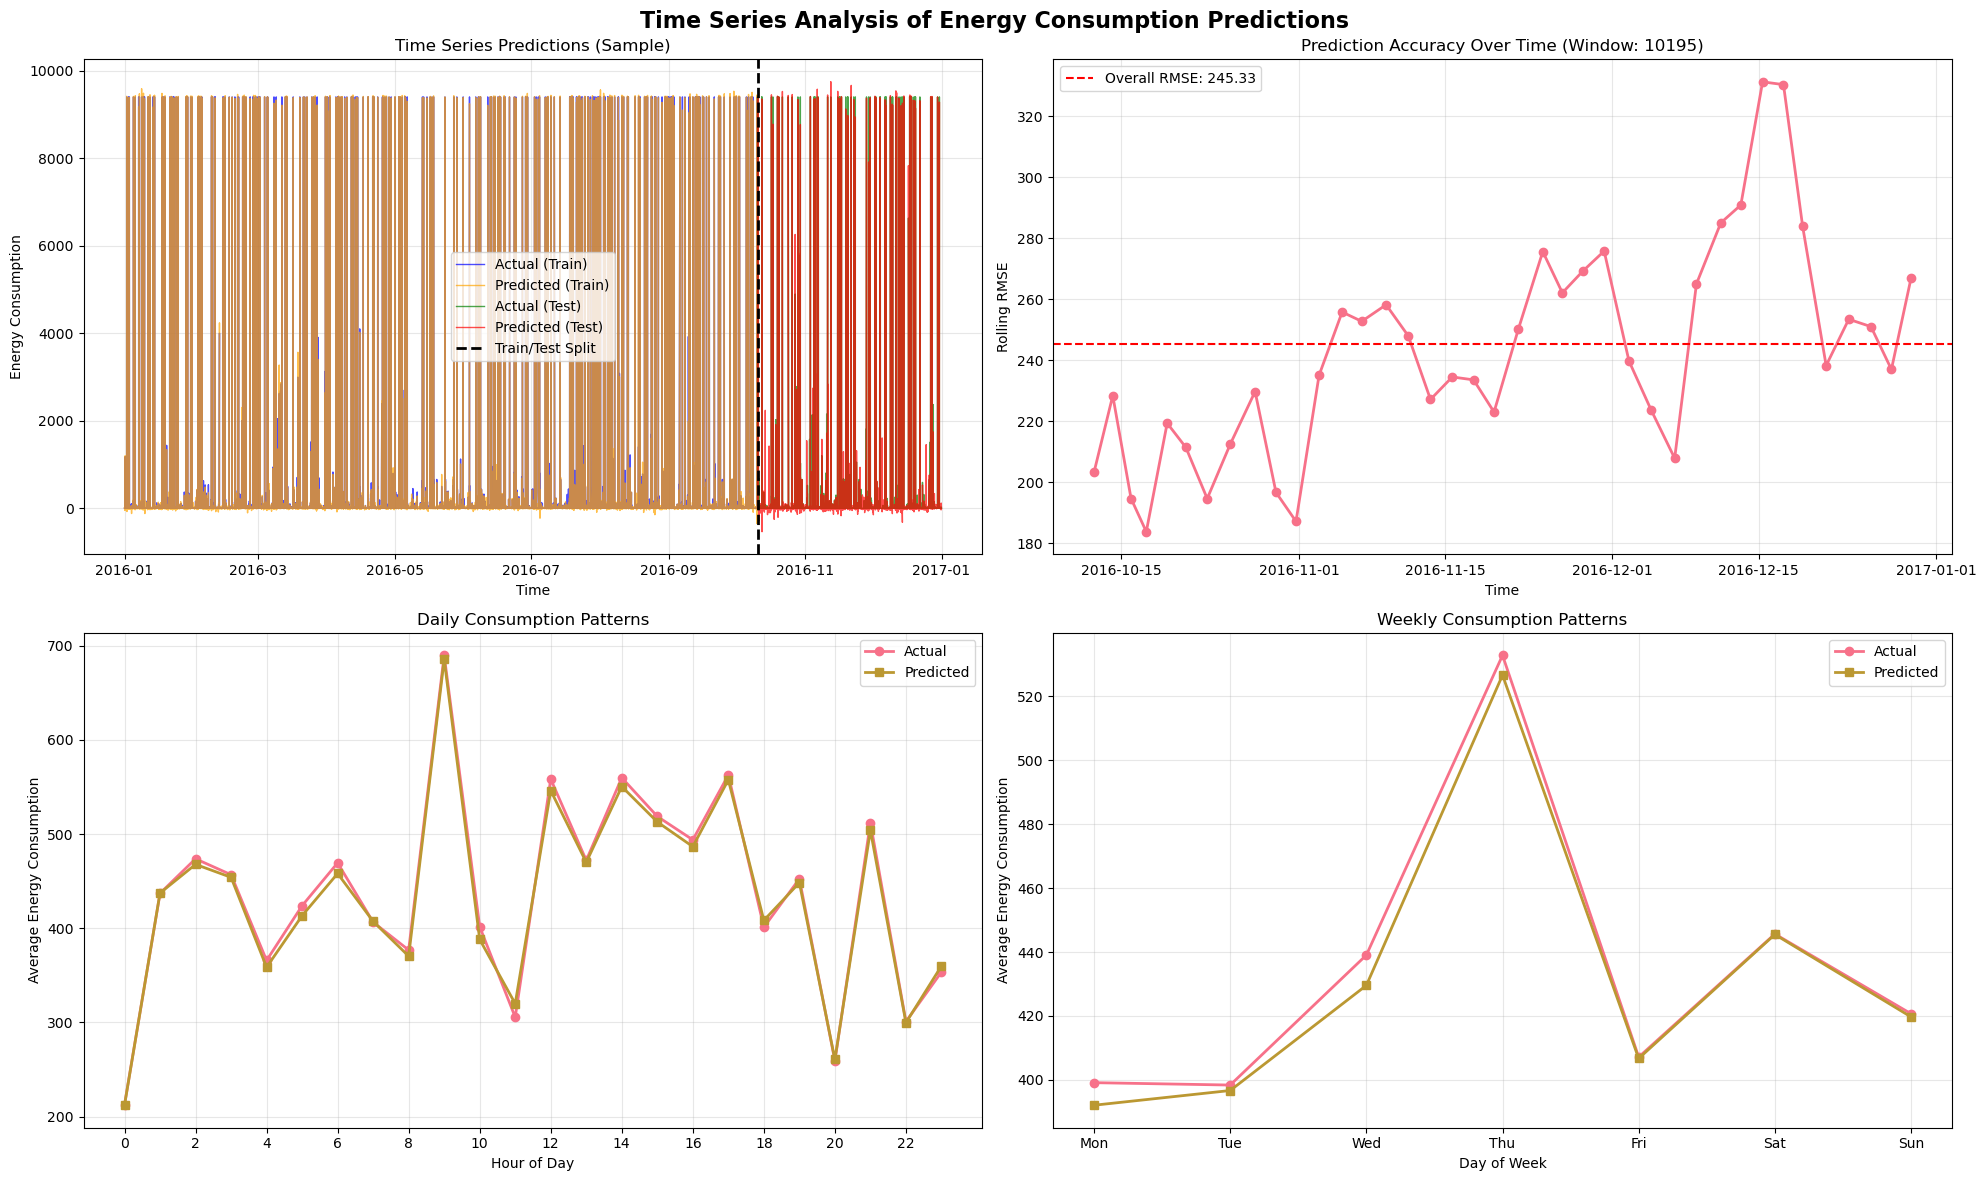


TEMPORAL PATTERN ANALYSIS
Hour with highest prediction error: 11:00
Error at peak hour: 14.40

Weekday vs Weekend Performance:
Weekday RMSE: 249.55
Weekend RMSE: 234.64
Difference: 14.91
✓ Time series analysis completed!


In [11]:
# Time series analysis and prediction visualization
print("Creating time series analysis...")

if has_timestamp:
    # Create time series predictions with timestamps
    timestamps_train = df['timestamp'].iloc[:split_idx]
    timestamps_test = df['timestamp'].iloc[split_idx:]
    
    # Create predictions dataframe for analysis
    predictions_df = pd.DataFrame({
        'timestamp': pd.concat([timestamps_train, timestamps_test]),
        'actual': pd.concat([y_train, y_test]),
        'predicted': np.concatenate([y_train_pred, y_test_pred]),
        'split': ['train'] * len(y_train) + ['test'] * len(y_test)
    })
    
    # Sample data for visualization (to avoid overcrowding)
    n_sample = min(10000, len(predictions_df))
    sample_df = predictions_df.sample(n=n_sample, random_state=42).sort_values('timestamp')
    
    # Create time series visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Time Series Analysis of Energy Consumption Predictions', fontsize=16, fontweight='bold')
    
    # 1. Time series plot (sampled data)
    train_sample = sample_df[sample_df['split'] == 'train']
    test_sample = sample_df[sample_df['split'] == 'test']
    
    axes[0, 0].plot(train_sample['timestamp'], train_sample['actual'], 
                   alpha=0.7, label='Actual (Train)', linewidth=1, color='blue')
    axes[0, 0].plot(train_sample['timestamp'], train_sample['predicted'], 
                   alpha=0.7, label='Predicted (Train)', linewidth=1, color='orange')
    axes[0, 0].plot(test_sample['timestamp'], test_sample['actual'], 
                   alpha=0.7, label='Actual (Test)', linewidth=1, color='green')
    axes[0, 0].plot(test_sample['timestamp'], test_sample['predicted'], 
                   alpha=0.7, label='Predicted (Test)', linewidth=1, color='red')
    
    axes[0, 0].axvline(x=timestamps_test.iloc[0], color='black', linestyle='--', 
                      label='Train/Test Split', linewidth=2)
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Energy Consumption')
    axes[0, 0].set_title('Time Series Predictions (Sample)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Prediction accuracy over time (Test set only)
    # Calculate rolling RMSE
    test_predictions = predictions_df[predictions_df['split'] == 'test'].copy()
    test_predictions = test_predictions.sort_values('timestamp')
    
    # Calculate rolling RMSE over time windows
    window_size = max(100, len(test_predictions) // 20)  # 20 windows
    rolling_rmse = []
    time_windows = []
    
    for i in range(0, len(test_predictions) - window_size, window_size // 2):
        window_data = test_predictions.iloc[i:i+window_size]
        rmse = np.sqrt(mean_squared_error(window_data['actual'], window_data['predicted']))
        rolling_rmse.append(rmse)
        time_windows.append(window_data['timestamp'].iloc[window_size//2])
    
    axes[0, 1].plot(time_windows, rolling_rmse, marker='o', linewidth=2)
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Rolling RMSE')
    axes[0, 1].set_title(f'Prediction Accuracy Over Time (Window: {window_size})')
    axes[0, 1].axhline(y=test_metrics['RMSE'], color='r', linestyle='--', 
                      label=f'Overall RMSE: {test_metrics["RMSE"]:.2f}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Daily patterns analysis
    # Extract hour and day of week from test data
    test_with_time = test_predictions.copy()
    test_with_time['hour'] = test_with_time['timestamp'].dt.hour
    test_with_time['dayofweek'] = test_with_time['timestamp'].dt.dayofweek
    
    # Calculate average consumption by hour
    hourly_actual = test_with_time.groupby('hour')['actual'].mean()
    hourly_predicted = test_with_time.groupby('hour')['predicted'].mean()
    
    axes[1, 0].plot(hourly_actual.index, hourly_actual.values, 
                   marker='o', label='Actual', linewidth=2)
    axes[1, 0].plot(hourly_predicted.index, hourly_predicted.values, 
                   marker='s', label='Predicted', linewidth=2)
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Average Energy Consumption')
    axes[1, 0].set_title('Daily Consumption Patterns')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(range(0, 24, 2))
    
    # 4. Weekly patterns analysis
    # Calculate average consumption by day of week
    daily_actual = test_with_time.groupby('dayofweek')['actual'].mean()
    daily_predicted = test_with_time.groupby('dayofweek')['predicted'].mean()
    
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    axes[1, 1].plot(daily_actual.index, daily_actual.values, 
                   marker='o', label='Actual', linewidth=2)
    axes[1, 1].plot(daily_predicted.index, daily_predicted.values, 
                   marker='s', label='Predicted', linewidth=2)
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Average Energy Consumption')
    axes[1, 1].set_title('Weekly Consumption Patterns')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(range(7))
    axes[1, 1].set_xticklabels(day_names)
    
    plt.tight_layout()
    plt.show()
    
    # Summary of temporal patterns
    print(f"\n{'='*60}")
    print("TEMPORAL PATTERN ANALYSIS")
    print(f"{'='*60}")
    
    # Peak hours analysis
    hourly_diff = np.abs(hourly_actual - hourly_predicted)
    peak_error_hour = hourly_diff.idxmax()
    print(f"Hour with highest prediction error: {peak_error_hour:02d}:00")
    print(f"Error at peak hour: {hourly_diff[peak_error_hour]:.2f}")
    
    # Weekend vs weekday analysis
    weekday_mask = test_with_time['dayofweek'] < 5
    weekend_mask = test_with_time['dayofweek'] >= 5
    
    weekday_rmse = np.sqrt(mean_squared_error(
        test_with_time[weekday_mask]['actual'], 
        test_with_time[weekday_mask]['predicted']
    ))
    weekend_rmse = np.sqrt(mean_squared_error(
        test_with_time[weekend_mask]['actual'], 
        test_with_time[weekend_mask]['predicted']
    ))
    
    print(f"\nWeekday vs Weekend Performance:")
    print(f"Weekday RMSE: {weekday_rmse:.2f}")
    print(f"Weekend RMSE: {weekend_rmse:.2f}")
    print(f"Difference: {abs(weekday_rmse - weekend_rmse):.2f}")
    
else:
    print("! Timestamp not available - skipping time series analysis")
    print("Time series visualizations require timestamp column in the dataset")

print("✓ Time series analysis completed!")

## 6. Model Saving and Deployment Preparation

In [ ]:
# Save the trained model and metadata
print("Saving model and metadata for deployment...")

# Create models directory if it doesn't exist
import os
models_path = '/Users/saatwik/Documents/Energy-consumption-forecasting/models/'
os.makedirs(models_path, exist_ok=True)

# Save the LightGBM model
model_filename = f"{models_path}lgbm_energy_model.txt"
final_model.save_model(model_filename)
print(f"✓ Model saved to: {model_filename}")

# Save model metadata and performance metrics
metadata = {
    'model_type': 'LightGBM Regressor',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data_shape': {
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'features': len(feature_cols)
    },
    'performance_metrics': {
        'train_rmse': train_metrics['RMSE'],
        'test_rmse': test_metrics['RMSE'],
        'train_mae': train_metrics['MAE'],
        'test_mae': test_metrics['MAE'],
        'train_r2': train_metrics['R²'],
        'test_r2': test_metrics['R²'],
        'train_mape': train_metrics['MAPE'],
        'test_mape': test_metrics['MAPE']
    },
    'hyperparameters': best_params,
    'feature_names': feature_cols,
    'cross_validation': {
        'cv_score': best_score,
        'cv_method': 'TimeSeriesSplit',
        'n_folds': 3
    }
}

# Save metadata as JSON
import json
metadata_filename = f"{models_path}model_metadata.json"
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"✓ Model metadata saved to: {metadata_filename}")

# Save feature importance
importance_df_full = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importance(importance_type='gain'),
    'Split_Importance': final_model.feature_importance(importance_type='split')
}).sort_values('Importance', ascending=False)

importance_filename = f"{models_path}feature_importance.csv"
importance_df_full.to_csv(importance_filename, index=False)
print(f"✓ Feature importance saved to: {importance_filename}")

# Save predictions for analysis
predictions_filename = f"{models_path}predictions_analysis.csv"
if has_timestamp:
    predictions_df.to_csv(predictions_filename, index=False)
    print(f"✓ Predictions analysis saved to: {predictions_filename}")
else:
    # Create predictions without timestamp
    pred_analysis = pd.DataFrame({
        'actual': pd.concat([y_train, y_test]),
        'predicted': np.concatenate([y_train_pred, y_test_pred]),
        'split': ['train'] * len(y_train) + ['test'] * len(y_test)
    })
    pred_analysis.to_csv(predictions_filename, index=False)
    print(f"✓ Predictions analysis saved to: {predictions_filename}")

# Create deployment script template
deployment_script = f'''"""
Energy Consumption Forecasting - Model Deployment Script
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

import lightgbm as lgb
import pandas as pd
import numpy as np
import json

class EnergyConsumptionPredictor:
    def __init__(self, model_path="{model_filename}", metadata_path="{metadata_filename}"):
        """Initialize the predictor with trained model and metadata"""
        self.model = lgb.Booster(model_file=model_path)
        
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        
        self.feature_names = self.metadata['feature_names']
        print(f"Model loaded successfully!")
        print(f"Expected features: {{len(self.feature_names)}}")
        print(f"Model performance - Test RMSE: {{self.metadata['performance_metrics']['test_rmse']:.2f}}")
    
    def predict(self, X):
        """Make predictions on new data"""
        # Ensure features are in correct order
        if isinstance(X, pd.DataFrame):
            X = X[self.feature_names]
        
        predictions = self.model.predict(X)
        return predictions
    
    def get_feature_importance(self):
        """Get feature importance rankings"""
        importance = self.model.feature_importance(importance_type='gain')
        return pd.DataFrame({{
            'Feature': self.feature_names,
            'Importance': importance
        }}).sort_values('Importance', ascending=False)

# Example usage:
# predictor = EnergyConsumptionPredictor()
# predictions = predictor.predict(new_data)
'''

deployment_filename = f"{models_path}deployment_script.py"
with open(deployment_filename, 'w') as f:
    f.write(deployment_script)
print(f"✓ Deployment script saved to: {deployment_filename}")

# Final summary
print(f"\n{'='*80}")
print("ENERGY CONSUMPTION FORECASTING MODEL - TRAINING COMPLETE")
print(f"{'='*80}")

print(f"\nModel Performance Summary:")
print(f"{'─'*40}")
print(f"Final Test RMSE:        {test_metrics['RMSE']:>10.2f}")
print(f"Final Test MAE:         {test_metrics['MAE']:>10.2f}")
print(f"Final Test R²:          {test_metrics['R²']:>10.4f}")
print(f"Final Test MAPE:        {test_metrics['MAPE']:>9.2f}%")

print(f"\nModel Configuration:")
print(f"{'─'*40}")
print(f"Training samples:       {len(X_train):>10,}")
print(f"Test samples:           {len(X_test):>10,}")
print(f"Features used:          {len(feature_cols):>10}")
if best_score != float('inf'):
    print(f"CV RMSE:               {best_score:>10.4f}")
else:
    print(f"CV RMSE:               {'N/A (fallback)':>10}")
print(f"Best iteration:         {final_model.best_iteration:>10}")

if has_timestamp:
    print(f"\nTemporal Analysis:")
    print(f"{'─'*40}")
    print(f"Time series split:      ✓ Applied")
    print(f"Training period:        {df['timestamp'].iloc[0].strftime('%Y-%m-%d')} to {df['timestamp'].iloc[split_idx-1].strftime('%Y-%m-%d')}")
    print(f"Test period:            {df['timestamp'].iloc[split_idx].strftime('%Y-%m-%d')} to {df['timestamp'].iloc[-1].strftime('%Y-%m-%d')}")
    
    if 'weekday_rmse' in locals() and 'weekend_rmse' in locals():
        print(f"Weekday RMSE:           {weekday_rmse:>10.2f}")
        print(f"Weekend RMSE:           {weekend_rmse:>10.2f}")

print(f"\nFiles Generated:")
print(f"{'─'*40}")
print(f"Model file:             {os.path.basename(model_filename)}")
print(f"Metadata:               {os.path.basename(metadata_filename)}")
print(f"Feature importance:     {os.path.basename(importance_filename)}")
print(f"Predictions analysis:   {os.path.basename(predictions_filename)}")
print(f"Deployment script:      {os.path.basename(deployment_filename)}")

print(f"\nTop 5 Most Important Features:")
print(f"{'─'*40}")
for idx, (_, row) in enumerate(importance_df_full.head().iterrows(), 1):
    print(f"{idx}. {row['Feature']:<25} {row['Importance']:>8.1f}")

print(f"\n{'='*80}")
print("🎉 MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY! 🎉")
print(f"{'='*80}")
print("\nNext steps:")
print("1. Review model performance metrics and visualizations")
print("2. Use deployment_script.py for making predictions on new data")
print("3. Consider model monitoring and retraining schedule")
print("4. Deploy model to production environment")

print("✓ All tasks completed successfully!")